<a href="https://colab.research.google.com/github/UERJ-FISICA/ML4PPGF_UERJ/blob/PPGF-2022-1/06_Classifica%C3%A7%C3%A3o_D%C3%ADgitos_BDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

import sklearn
print ( sklearn.__version__ )

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

0.23.2


In [2]:
train_model = True
run_grid_search = True
save_model = True

model_path = ""
scaler_path = ""
if not train_model:
#     model_path = "ada_clf.joblib"
    model_path = "models/BDT/ada_clf.joblib"
#     scaler_path = "standard_scaler.joblib"
    scaler_path = "models/BDT/standard_scaler.joblib"

### Amostra de dígitos

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)
X_train_raw = mnist.data[:60000]
y_train = mnist.target[:60000]
X_test_raw = mnist.data[60000:]
y_test = mnist.target[60000:]

print ( X_train_raw.shape )
print ( X_test_raw.shape )

(60000, 784)
(10000, 784)


### Renormalização dos dados

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = None
X_train = None
if train_model:
    scaler = StandardScaler()
    X_train = scaler.fit_transform( X_train_raw )
else:
    scaler = load( scaler_path )
    X_train = scaler.transform( X_train_raw )
X_test  = scaler.transform( X_test_raw )

print ( scaler )

if train_model and save_model:
#     dump( scaler, "standard_scaler.joblib")
    dump( scaler, "models/standard_scaler.joblib")
    
idx = 20000
print ( y_train[ idx ] )
print ( X_train[ idx ] )

StandardScaler()
3
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.00441808 -0.00575482 -0.00408252 -0.00408252  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.00408252 -0.00470969 -0.00879935 -0.01159056
 -0.01475898 -0.01928485 -0.0246718  -0.02907103 -0.03059266 -0.03116401
 -0.03196287 -0.03020254 -0.03131022 -0.0283834  -0.02311919 -0.01916663
 -0.0167723  -0.01099636 -0.00832486 -0.00438069  0.          0.
  0.          0.          0.          0.         -0.00408252 -0.00539535
 -0.00852241 -0.01198504 -0.01765348 -0.0277109  -0.03702009 -0.05215128
 -0.0670362  -0.08301705 -0.0993793  -0.11518413 -0.12913326 -0.13839468
 -0.13888363 -0.13184344 -0.12042952 -0.10189079 -0.0786049  -0.05699561
 -0.03965768 -0.02372839 -0.01408835 -0.00783084  0.          0.
  0.          0

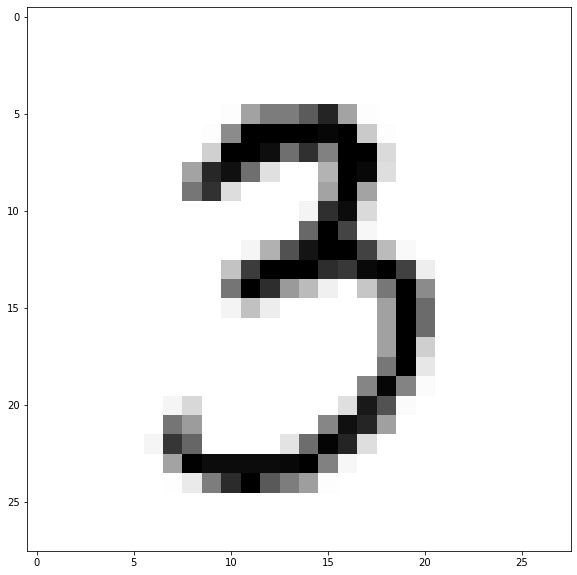

In [5]:
fig = plt.figure( figsize=(10,10) )
plt.imshow( X_train_raw[ idx ].reshape(28,28), cmap='binary' )

### Treinamento
### Hyperparameter scan

In [6]:
shuffle_index = np.random.permutation( 60000 )
X_train_shuffle, y_train_shuffle = X_train[ shuffle_index ], y_train[ shuffle_index ]

In [7]:
n_iter_search = 30 # número de configurações de parâmetros
cv = 4 # cross validation samples
njobs = 6

grid_search = None
if train_model and run_grid_search:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    from sklearn.model_selection import RandomizedSearchCV
    #from sklearn.model_selection import GridSearchCV

    param_distribs = {
        "base_estimator__max_depth": np.arange(2,5),
        "base_estimator__min_samples_split": np.arange(2,5),
        "n_estimators": 100 * np.arange(2,6),
        "learning_rate": 0.1 * np.arange(2,6)
        }

    grid_search = RandomizedSearchCV(
        AdaBoostClassifier(
            DecisionTreeClassifier(),
            algorithm="SAMME.R"
            ),
        param_distribs,
        n_iter=n_iter_search, cv=cv, verbose=20, n_jobs=njobs, random_state=42
        )
    grid_search.fit( X_train_shuffle[:10000], y_train_shuffle[:10000] )

    print ( grid_search.best_params_ )
    print ( grid_search.best_score_ )
    print ( grid_search.cv_results_ )
    
    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2022/04/11 08:01:05
Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed: 10.4min
[Parallel(

{'n_estimators': 500, 'learning_rate': 0.30000000000000004, 'base_estimator__min_samples_split': 3, 'base_estimator__max_depth': 4}
0.9105000000000001
{'mean_fit_time': array([207.38443434, 197.12308598, 225.70349556, 214.6189521 ,
       112.80433637,  81.00611484, 142.61941046, 167.60449833,
       227.34529495, 162.20973021, 283.67949289, 225.21092552,
       223.62292123, 213.92221951, 143.26989186, 113.40360808,
       203.93022025, 170.93351376, 215.33593601, 172.38483322,
       202.23038733, 355.4879837 , 284.22419477, 211.73229456,
       283.42839062, 120.62245142, 121.36466002,  82.48331457,
       163.57257789, 121.75319326]), 'std_fit_time': array([ 0.41699793,  4.10098808,  0.90255005,  0.45665939,  1.49899914,
        0.68759942,  0.59720007,  1.260374  ,  0.99437694,  0.72443512,
        0.46363889,  2.00403234,  0.88020583,  0.59717481,  1.03829246,
        0.48103308,  0.61933919,  1.58042386,  0.24262766,  1.13115061,
        2.00095072,  0.64658099,  1.16938211,  0.

### Modelo

In [ ]:
model_final = None

if train_model:
    max_depth_ = 4
    min_samples_split_ = 3
    n_estimators_ = 300
    learning_rate_ = 0.3
    if run_grid_search: 
#         model_final = grid_search.best_estimator_
        params_ = grid_search.best_params_
        max_depth_ = params_[ 'base_estimator__max_depth' ]
        min_samples_split_ = params_[ 'base_estimator__min_samples_split' ]
        n_estimators_ = params_[ 'n_estimators' ]
        learning_rate_ = params_[ 'learning_rate' ]
    
    model_final = AdaBoostClassifier(
            DecisionTreeClassifier(
                max_depth=max_depth_,
                min_samples_split=min_samples_split_
            ),
            n_estimators = n_estimators_,
            algorithm="SAMME.R",
            learning_rate = learning_rate_
            )
    model_final.fit( X_train_shuffle, y_train_shuffle )
else:
    model_final = load( model_path )
 
print ( model_final )

### Teste

In [ ]:
y_predict_test = model_final.predict( X_test )

accuracy = np.sum( y_predict_test == y_test ) / y_test.size
print ( "Accuracy = {}".format( accuracy ) )

In [ ]:
if train_model and save_model:
#     dump( model_final, "ada_clf.joblib" )
    dump( model_final, "models/ada_clf.joblib" )

In [ ]:
np.info( DecisionTreeClassifier )